In [1]:
# move to project's root directory to make numpy_nn package accessable 
%cd ..


# Another possible solution is appending to the sys.path

# import sys
# import  os
# project_root = os.path.dirname(sys.path[0])
# if project_root not in sys.path:
#     sys.path.append(project_root)

c:\Users\SystemPoint\Documents\GitHub\DNN_lab_1


In [2]:
import pickle
from collections import Counter


import numpy as np
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from tqdm import tqdm


from numpy_nn.modules.np_nn import (
    FullyConnectedLayer,
    ReLULayer,
    SigmoidLayer,
    ReLULayer,
    AdamOptimizer,
    CrossEntropyLoss,
    LinearActivation,
    Sequential,
    Optimizer,
    SoftMaxLayer,
    GradientDescentOptimizer,
    CrossEntropyLossWithSoftMax,
    softmax,
    Conv2d,
    Flatten,
    BatchNormalization2d,
)

from numpy_nn.models.resnet_without_batchnorm import resnet101

plt.gray()

<Figure size 432x288 with 0 Axes>

In [3]:
def one_hot(y: np.ndarray, n_classes: int):
    encoded = np.zeros((y.size, n_classes))
    encoded[np.arange(y.size), y] = 1
    return encoded

def padding(X, pad):
    batch_size, channels, h, w = X.shape
    out = np.zeros((batch_size, channels, h + 2 * pad, w + 2 * pad))
    out[:, :, pad:pad + h, pad:pad + w] = X
    return out

In [4]:
((X_train, y_train), (X_test, y_test)) = mnist.load_data()

In [5]:
y_train_value_counts = Counter(y_train)
y_test_value_counts = Counter(y_test)

for key in range(10):
    print(f"{key}: {y_train_value_counts[key]}", end = ' ')
print()
for key in range(10):
    print(f"{key}: {y_test_value_counts[key]}", end = ' ')

0: 5923 1: 6742 2: 5958 3: 6131 4: 5842 5: 5421 6: 5918 7: 6265 8: 5851 9: 5949 
0: 980 1: 1135 2: 1032 3: 1010 4: 982 5: 892 6: 958 7: 1028 8: 974 9: 1009 

In [6]:
X_train = padding(X_train.reshape(-1, 1, 28, 28), 2).astype(np.float32)
X_test = padding(X_test.reshape(-1, 1, 28, 28), 2).astype(np.float32)
y_train = one_hot(y_train, 10)
y_test = one_hot(y_test, 10)

In [7]:
y_train.shape, X_train.shape

((60000, 10), (60000, 1, 32, 32))

In [8]:
X_train = X_train/255
X_test = X_test/255

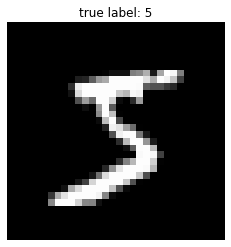

In [9]:
plt.axis('off')
plt.title(f"true label: {np.argmax(y_train[0])}")
plt.imshow(X_train[0].reshape(32, 32))

In [10]:
# The history is calculated for the whole epoch in implementation below

def train(model, X_train: np.ndarray, y_train: np.ndarray, X_test: np.ndarray, y_test: np.ndarray,
          optimizer: Optimizer, loss, epochs: int, batch_size: int, metric_names, epoch_history):
    
    for i in range(epochs):
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
                X, y = X_train, y_train
            elif phase == 'test':
                model.eval()
                X, y = X_test, y_test
            
            print(phase)
            epoch_loss = 0
            
            all_true_y = []
            all_pred_y = []
            
            batch_pbar = tqdm(range(0, X.shape[0], batch_size))
            
            for j in batch_pbar:
                # print(f"epoch {i} batch {j}")
                X_b, y_b = X[j:j+batch_size], y[j:j+batch_size]
                y_pred = model.forward(X_b)
                loss_val = loss.forward(y_pred, y_b)

                y_pred_label_b = np.argmax(y_pred, axis=1)
                y_true_label_b = np.argmax(y_b, axis=1)
                
                batch_results = {
                    'loss': loss_val,
                    'accuracy': np.mean(np.array(y_pred_label_b) == np.array(y_true_label_b)),
                    'f1_score': f1_score(y_pred_label_b, y_true_label_b, average='macro'),
                }
                
                all_pred_y.extend(y_pred_label_b)
                all_true_y.extend(y_true_label_b)
                epoch_loss += loss_val

                if phase == 'train':
                    loss_gradient = loss.backward()
                    model.backward(loss_gradient)
                    optimizer.step()
                
                progress_string = "batch: "
                for metric_name in batch_results:
                    progress_string+=f"{metric_name}: {batch_results[metric_name]:.2f}  "
                batch_pbar.set_description(progress_string)
                
            epoch_history[phase]['accuracy'].append(np.mean(np.array(all_pred_y) == np.array(all_true_y)))
            epoch_history[phase]['f1_score'].append(f1_score(all_pred_y, all_true_y, average='macro'))
            epoch_history[phase]['loss'].append(epoch_loss)
            
            print(f"epoch metrics: loss = {epoch_history[phase]['loss'][-1]:.4f}, \
                accuracy = {epoch_history[phase]['accuracy'][-1]:.4f}, \
                f score = {epoch_history[phase]['f1_score'][-1]:.4f}")
            
            
            
            epoch_history_name = 'numpy_resnet_epoch_history.pickle'

            with open(epoch_history_name, 'wb') as f:
                pickle.dump(epoch_history, f)

            # with open(epoch_history_name, 'rb') as f:
            #     epoch_history = pickle.load(f)
            
            for layer in model.trainable_layers:
                layer.input_ = None
            
            model_file_name = 'numpy_resnet_1.pickle'

            with open(model_file_name, 'wb') as f:
                pickle.dump(model, f)
            
            adam_name = './numpy_resnet_adam.pickle'

            with open(adam_name, 'wb') as f:
                pickle.dump(optimizer, f)

In [11]:
# Conv2d.backward = Conv2d.backward_as_mat_mul_unified

In [12]:
model = resnet101(10, 1)
# optimizer = GradientDescentOptimizer(model.trainable_layers, learning_rate = 1e-3)
optimizer = AdamOptimizer(model.trainable_layers, learning_rate = 1e-3)
loss = CrossEntropyLossWithSoftMax()

In [13]:
# import pickle
# model_file_name = 'numpy_resnet_1_epoch_train[:6400]_test[:1000].pickle'
# with open(model_file_name, 'rb') as f:
#     model = pickle.load(f)
# # Forgot to save optimizer :(
# optimizer = AdamOptimizer(model.trainable_layers, learning_rate = 1e-3)
# loss = CrossEntropyLossWithSoftMax()

In [15]:
# ! Decided that probably torch  follows the best initialization
# practices which may lead to better performance

from pytorch_nn.models.resnet import resnet101 as resnet101_torch

torch_resnet = resnet101_torch(10, 1)

model.clone_weights_from_torch(torch_resnet)

c:\Users\SystemPoint\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
# Model weights over 5 Gb due to saving of converted inputs in Conv2d
!du --block-size=1MB ./numpy_resnet_1.pickle

"du" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


In [17]:
# epochs = 2
# batch_size = 32
# dataset_percent = 100
# history = train(
#     model, X_train[0:640*dataset_percent], y_train[0:640*dataset_percent],
#     X_test[0:100*dataset_percent], y_test[0:100*dataset_percent],
#     optimizer, loss, epochs, batch_size)

In [ ]:
# model_file_name = 'numpy_resnet_1.pickle'

# # with open(model_file_name, 'wb') as f:
# #     pickle.dump(model, f)

# with open(model_file_name, 'rb') as f:
#     model = pickle.load(f)

# model.eval()



# history_name = 'numpy_resnet_epoch_history.pickle'

# # with open(history_name, 'wb') as f:
# # #     pickle.dump(epoch_history, f)

# with open(history_name, 'rb') as f:
#     epoch_history = pickle.load(f)


# adam_name = './numpy_resnet_adam.pickle'

# # with open(history_name, 'wb') as f:
# #     pickle.dump(optimizer, f)

# with open(adam_name, 'rb') as f:
#     optimizer = pickle.load(f)
    
# loss = CrossEntropyLossWithSoftMax()

In [16]:
metric_names = ['loss', 'accuracy', 'f1_score']
epoch_history = {phase_name: {metric_name: [] for metric_name in metric_names} for phase_name in ['train', 'test']}

In [17]:
metric_names = ['loss', 'accuracy', 'f1_score']

model_file_name = 'numpy_resnet_1.pickle'

# with open(model_file_name, 'wb') as f:
#     pickle.dump(model, f)

with open(model_file_name, 'rb') as f:
    model = pickle.load(f)

model.eval()



history_name = 'numpy_resnet_epoch_history.pickle'

# with open(history_name, 'wb') as f:
# #     pickle.dump(epoch_history, f)

with open(history_name, 'rb') as f:
    epoch_history = pickle.load(f)



adam_name = './numpy_resnet_adam.pickle'

# with open(adam_name, 'wb') as f:
#     pickle.dump(optimizer, f)

with open(adam_name, 'rb') as f:
    optimizer = pickle.load(f)

optimizer.trainable_layers = model.trainable_layers

for layer in optimizer.trainable_layers:
    for _, _, id in layer.get_parameters_and_gradients_and_ids():
        if not id in optimizer.m.keys():
            print("problem")

FileNotFoundError: [Errno 2] No such file or directory: 'numpy_resnet_1.pickle'

In [18]:
epochs = 3

batch_size = 64
train(
    model, X_train, y_train,
    X_test, y_test,
    optimizer, loss, epochs, batch_size,
    metric_names, epoch_history)
model.eval()

train


batch: loss: 2.30  accuracy: 0.08  f1_score: 0.01  :   0%|          | 1/938 [00:31<8:11:52, 31.50s/it]


KeyboardInterrupt: 

In [ ]:
# epochs = 1
# batch_size = 1
# history = train(
#     model, X_train[0:3], y_train[0:3],
#     X_test[0:3], y_test[0:3],
#     optimizer, loss, epochs, batch_size)

In [17]:
for layer in model.trainable_layers:
    layer.input_ = None

In [98]:
print(epoch_history)

{'train': {'loss': [637.6428829046307, 87.40081899258857, 59.935969895313534, 46.62375996563097, 52.942474304686804, 36.91081450468731, 33.12493823827702, 31.63008634778216, 29.1537114473998, 26.266286148592584, 27.958398730476077, 29.72671108802675, 22.931614962432107, 23.536148009387432, 25.857171588507665, 21.827094054657014, 18.136576181624974, 22.997600786472344, 16.667646778568386], 'accuracy': [0.7387666666666667, 0.9743833333333334, 0.9823166666666666, 0.9862833333333333, 0.98425, 0.9894333333333334, 0.9903, 0.9909166666666667, 0.9915333333333334, 0.9924, 0.9919, 0.9905166666666667, 0.99325, 0.99285, 0.99255, 0.99365, 0.9945333333333334, 0.9937666666666667, 0.9950166666666667], 'f1_score': [0.7397942102131722, 0.9742358241166679, 0.9822247446037515, 0.9862095697545807, 0.9841285706534771, 0.9893639339157273, 0.9902414013428119, 0.9908750152782708, 0.9914626220445326, 0.9923541816509911, 0.991866834143529, 0.9904535795797905, 0.9932350097544905, 0.9928254073756648, 0.99254779564

In [40]:
def plot_history(history_list):
    history1 = history_list[0]
    phases = list(history1.keys())
    fig, axs = plt.subplots(len(phases), len(history1[phases[0]]))

    fig.set_figheight(10)
    fig.set_figwidth(20)

    for phase_index, phase in enumerate(phases):
        for key_index, (key, value) in enumerate(history1[phase].items()):
            for history in history_list:
                axs[phase_index][key_index].plot(history[phase][key])
            axs[phase_index][key_index].set_title(f"{phase} {key}")
    plt.show()


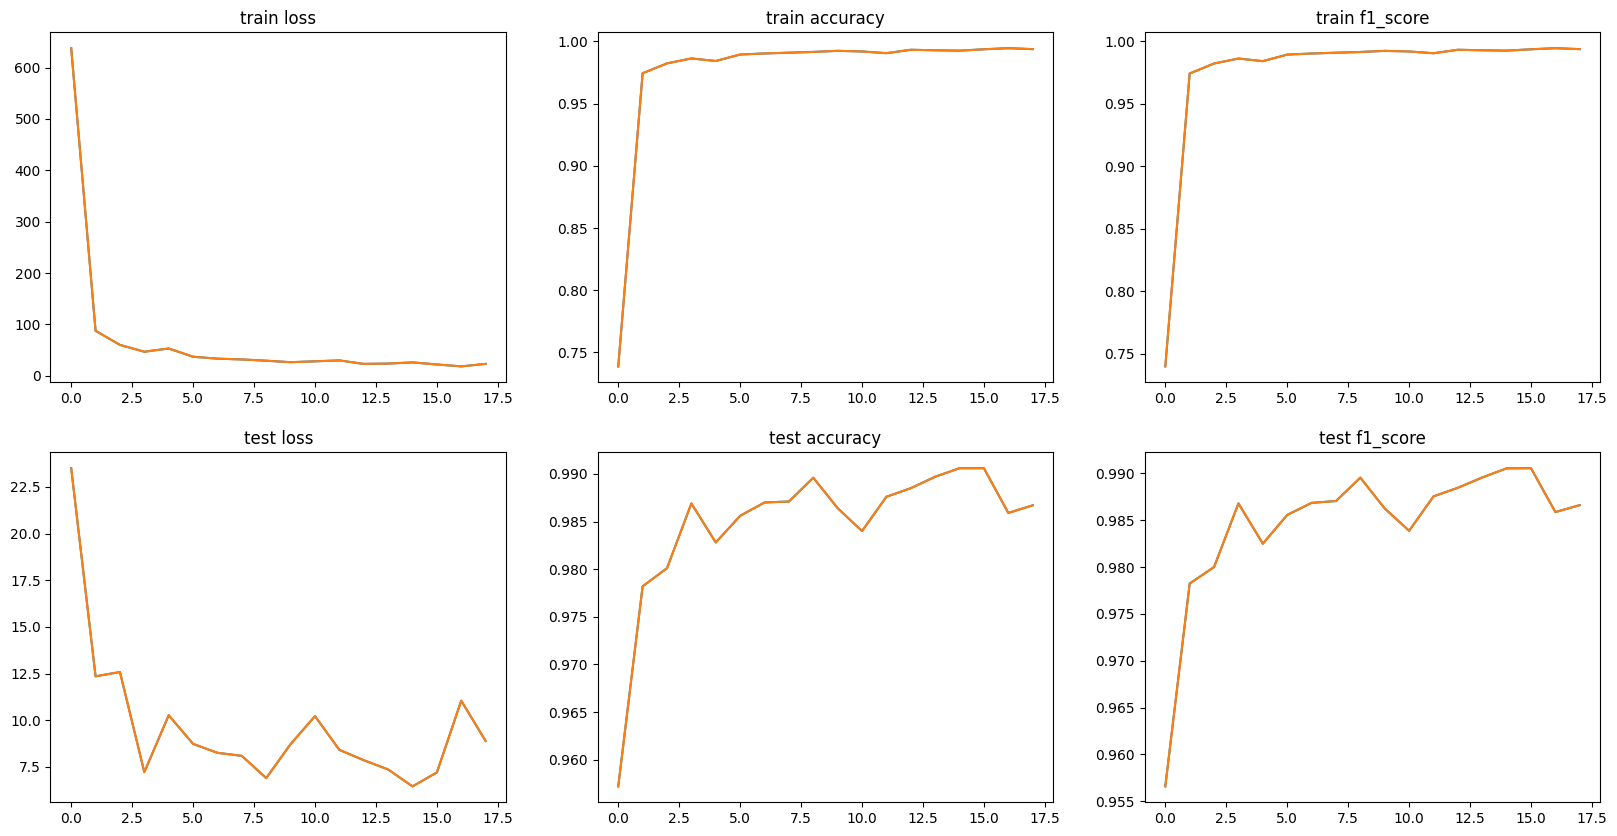

In [96]:
plot_history([epoch_history])

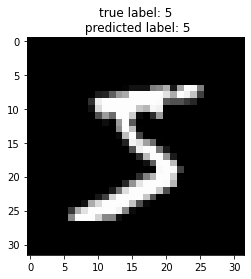

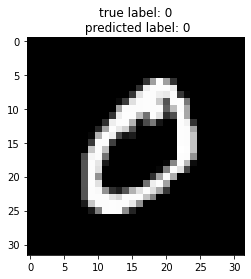

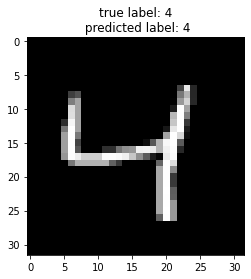

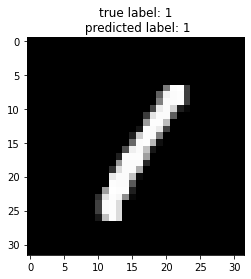

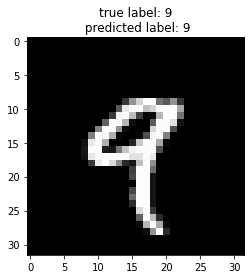

In [24]:
for i in range(5):
    probs_i = softmax(model.forward(X_train[i].reshape(1, 1, 32, 32)))
    plt.title(f"true label: {np.argmax(y_train[i])}\n predicted label: {np.argmax(probs_i)}")
    plt.imshow(X_train[i].reshape(32, 32))
    plt.show()

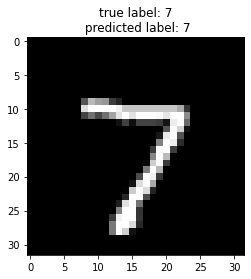

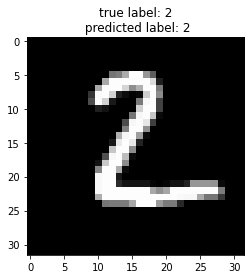

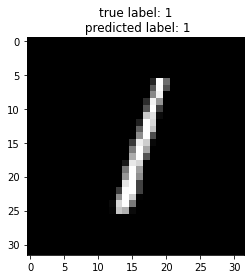

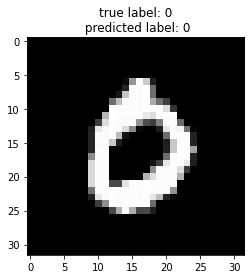

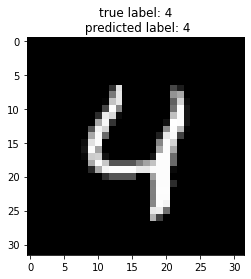

In [25]:
for i in range(5):
    probs_i = softmax(model.forward(X_test[i].reshape(1, 1, 32, 32)))
    plt.title(f"true label: {np.argmax(y_test[i])}\n predicted label: {np.argmax(probs_i)}")
    plt.imshow(X_test[i].reshape(32, 32))
    plt.show()

# Small CNN

In [34]:
_, in_channels, height, width, = X_train.shape
out_channels = 32
kernel_size = 3
stride = 1
padding = 1
bias = True


batch_size = 64
epochs = 5
weights_data = []

model_small_cnn = Sequential([
    Conv2d(in_channels, out_channels, kernel_size, stride, padding), ReLULayer(),
    # Conv2d(out_channels, out_channels, kernel_size, stride, padding), ReLULayer(),
    Flatten(), FullyConnectedLayer(height * width * out_channels, 10)])
# optimizer = GradientDescentOptimizer(model.trainable_layers, learning_rate = 1e-3)
optimizer_small_cnn = AdamOptimizer(model_small_cnn.trainable_layers, learning_rate = 1e-3)
loss = CrossEntropyLossWithSoftMax()

metric_names = ['loss', 'accuracy', 'f1_score']
epoch_history_small_cnn = {phase_name: {metric_name: [] for metric_name in metric_names} for phase_name in ['train', 'test']}
# epoch_history_small_cnn['experimant_name'] = 'small cnn'

train(model_small_cnn, X_train, y_train, X_test, y_test, optimizer_small_cnn, loss, epochs, batch_size, metric_names, epoch_history_small_cnn)

train


batch: loss: 0.03  accuracy: 1.00  f1_score: 1.00  : 100%|███████████████████████████| 938/938 [11:58<00:00,  1.31it/s]


epoch metrics: loss = 154.8226,                 accuracy = 0.9528,                 f score = 0.9525
test


batch: loss: 0.00  accuracy: 1.00  f1_score: 1.00  : 100%|███████████████████████████| 157/157 [00:41<00:00,  3.80it/s]


epoch metrics: loss = 12.2120,                 accuracy = 0.9757,                 f score = 0.9756
train


batch: loss: 0.01  accuracy: 1.00  f1_score: 1.00  : 100%|███████████████████████████| 938/938 [12:09<00:00,  1.28it/s]


epoch metrics: loss = 62.6933,                 accuracy = 0.9802,                 f score = 0.9801
test


batch: loss: 0.00  accuracy: 1.00  f1_score: 1.00  : 100%|███████████████████████████| 157/157 [01:03<00:00,  2.48it/s]


epoch metrics: loss = 10.4040,                 accuracy = 0.9777,                 f score = 0.9776
train


batch: loss: 0.01  accuracy: 1.00  f1_score: 1.00  : 100%|███████████████████████████| 938/938 [12:32<00:00,  1.25it/s]


epoch metrics: loss = 46.9348,                 accuracy = 0.9857,                 f score = 0.9857
test


batch: loss: 0.00  accuracy: 1.00  f1_score: 1.00  : 100%|███████████████████████████| 157/157 [00:43<00:00,  3.57it/s]


epoch metrics: loss = 9.9350,                 accuracy = 0.9789,                 f score = 0.9788
train


batch: loss: 0.00  accuracy: 1.00  f1_score: 1.00  : 100%|███████████████████████████| 938/938 [12:21<00:00,  1.27it/s]


epoch metrics: loss = 37.6606,                 accuracy = 0.9887,                 f score = 0.9886
test


batch: loss: 0.00  accuracy: 1.00  f1_score: 1.00  : 100%|███████████████████████████| 157/157 [00:40<00:00,  3.86it/s]


epoch metrics: loss = 9.6562,                 accuracy = 0.9798,                 f score = 0.9797
train


batch: loss: 0.00  accuracy: 1.00  f1_score: 1.00  : 100%|███████████████████████████| 938/938 [14:51<00:00,  1.05it/s]


epoch metrics: loss = 30.8041,                 accuracy = 0.9910,                 f score = 0.9910
test


batch: loss: 0.00  accuracy: 1.00  f1_score: 1.00  : 100%|███████████████████████████| 157/157 [00:40<00:00,  3.84it/s]


epoch metrics: loss = 10.0537,                 accuracy = 0.9801,                 f score = 0.9800


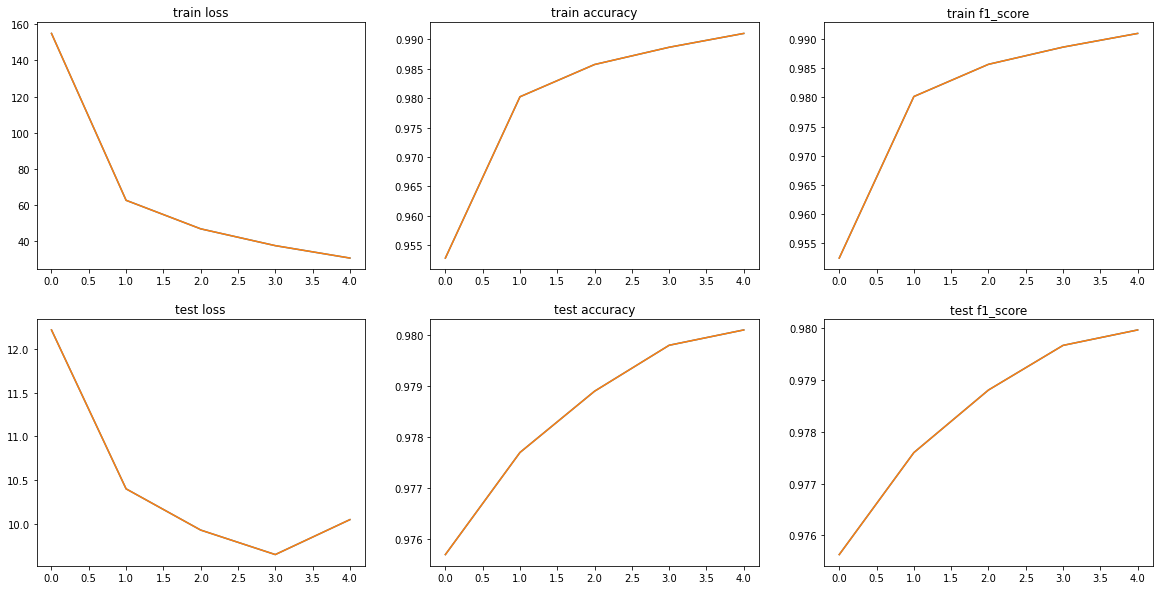

In [43]:
plot_history([epoch_history_small_cnn])

In [ ]:
import torch

In [ ]:
X_train_torch = torch.from_numpy(X_train).float()
y_train_torch = torch.from_numpy(y_train)

X_test_torch = torch.from_numpy(X_test).float()
y_test_torch = torch.from_numpy(y_test)

def train_torch(model, X_train: torch.Tensor, y_train: torch.Tensor, X_test: torch.Tensor, y_test: torch.Tensor,
          optimizer, loss, epochs: int, batch_size: int):
    
    metric_names = ['loss', 'accuracy', 'f1_score']
    history = {phase_name: {metric_name: [] for metric_name in metric_names} for phase_name in ['train', 'test']}

    for i in range(epochs):
        for j in tqdm(range(0, X_train.shape[0], batch_size)):
            # print(f"epoch {i} batch {j}")
            X_b_train = X_train[j:j+batch_size]
            y_b_train = y_train[j:j+batch_size]
            y_pred = model(X_b_train)
            loss_val = loss(y_pred, y_b_train)
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            y_pred_label = np.argmax(y_pred.detach().numpy(), axis=1)
            y_true_label = np.argmax(y_b_train.detach().numpy(), axis=1)

            history['train']['accuracy'].append(np.mean(y_pred_label == y_true_label).item())
            history['train']['loss'].append(loss_val.item())
            history['train']['f1_score'].append(f1_score(y_true_label, y_pred_label, average='macro').item())
            
    return history

In [ ]:
in_channels = 1
out_channels = 32
kernel_size = 3
stride = 1
padding = 1
bias = True

height = X_train[0].shape[1]
width = X_train[0].shape[2]

batch_size = 1024
epochs = 3

model_torch = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
    torch.nn.ReLU(),
    torch.nn.Flatten(), 
    torch.nn.Linear(height * width * out_channels, 10),
)

weights_data_torch = []

optimizer_torch = torch.optim.Adam(model_torch.parameters(), lr=1e-3)

loss_torch = torch.nn.CrossEntropyLoss()

history_torch = train_torch(model_torch, X_train_torch, y_train_torch, X_test_torch, y_test_torch, optimizer_torch, loss_torch, epochs, batch_size)

In [ ]:
for key, value in history_torch['train'].items():
    plt.plot(value)
    plt.title(key)
    plt.show()